In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.oceandrift import OceanDrift
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, plotTrajectoriesFile, Field
from netCDF4 import Dataset
from matplotlib import pyplot as plt
from datetime import timedelta
import numpy as np

#np.random.seed(13435)

In [3]:
def simulate_parcels(source_url, output_filename, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    filenames = {'U' : source_url, 'V': source_url}
    dimensions = {'lat': 'lat','lon': 'lon','time': 'time'}

    if velocity_average: 
        variables = {'U': 'ubar', 'V': 'vbar'}
    else:
        variables = {'U': 'u', 'V': 'v'}

    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, interp_method = 'cgrid_velocity')
    
    if wind_drift_percentage:
        Uwind = Field.from_netcdf(source_url, ('U', 'Uwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Vwind = Field.from_netcdf(source_url, ('V', 'Vwind'), dimensions, field_chunksize='auto', interp_method = 'cgrid_velocity')
        Uwind.set_scaling_factor(wind_drift_percentage)
        Vwind.set_scaling_factor(wind_drift_percentage)
        fieldset = FieldSet(U = fieldset.U+ Uwind,V = fieldset.V+ Vwind)

    pset = ParticleSet.from_list(fieldset = fieldset, pclass = JITParticle, lon=lon, lat=lat)
    output_file = pset.ParticleFile(name = output_filename, outputdt = timedelta(minutes=15))

    pset.execute(AdvectionRK4, runtime = timedelta(hours = hours), dt = timedelta(minutes=5), output_file = output_file)

    output_file.export()

In [4]:
def simulate_opendrift(source_url, lat, lon, wind_drift_percentage, velocity_average, hours=23):
    reader_norkyst = reader_netCDF_CF_generic.Reader(source_url)
    o = OceanDrift(loglevel=20)
    
    if velocity_average:
        reader_norkyst.variable_mapping['x_sea_water_velocity'] = 'ubar'
        reader_norkyst.variable_mapping['y_sea_water_velocity'] = 'vbar'
    
    o.add_reader(reader_norkyst, variables=['x_sea_water_velocity', 'y_sea_water_velocity', 'x_wind', 'y_wind'])
    
    o.seed_elements(lon= lon, lat=lat, radius=1, number=1, time=reader_norkyst.start_time, wind_drift_factor = wind_drift_percentage)
    
    o.set_config('drift:scheme', 'runge-kutta4')
    
    o.run(duration = timedelta(hours=hours), time_step = 300, time_step_output = 900)
    
    return o

In [5]:
def plot_compare(parcels_file, opendrift_obj = None):
    
    pfile = Dataset(parcels_file)
    #time = pfile.variables['time']
    plon = np.ma.filled(pfile.variables['lon'], np.nan)
    plat = np.ma.filled(pfile.variables['lat'], np.nan)
    fig, ax = plt.subplots(1, 1)
    ax.plot(np.transpose(plon), np.transpose(plat), '-')
    
    if (opendrift_obj != None):
        olon, olat = opendrift_obj.get_lonlats()
        ax.plot(olon.T, olat.T)


In [6]:
source_url =  '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'
lon, lat = 14.1,69.4

In [7]:
simulate_parcels(source_url, 'ex1_nwnv.nc', lat,lon,0.0,False,23) #no wind. surface velocity
simulate_parcels(source_url, 'ex2_wnv.nc', lat,lon,0.02,False,23) #wind, surface velocity
simulate_parcels(source_url, 'ex3_nwv.nc', lat,lon,0.0,True,23) #no wind, average velocity
simulate_parcels(source_url, 'ex4_wv.nc', lat,lon,0.02,True,23) #wind, average velocity

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/14cddaee612c3dc00129a57117b4424b_0.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/14cddaee612c3dc00129a57117b4424b_0.so
INFO: Temporary output files are stored in out-MYUMWZRM.
INFO:parcels.tools.loggers:Temporary output files are stored in out-MYUMWZRM.
INFO: You can use "parcels_convert_npydir_to_netcdf out-MYUMWZRM" to convert these to a NetCDF file during the run.
INFO:parcels.tools.loggers:You can use "parcels_convert_npydir_to_netcdf out-MYUMWZRM" to convert these to a NetCDF file during the run.
100% (82800.0 of 82800.0) |##############| Elapsed Time: 0:01:04 Time:  0:01:04
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/d319175eeb962cf6c329030c2a3b5463_0.so
INFO:parcels.tools.loggers:Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1001/d319175eeb962cf6c329030c2a3b5463_0.so
INFO: Temporary output files are stored in out-DMHSZYUH.
INFO:parcels.tools.loggers:Temporary 

In [8]:
#plotTrajectoriesFile('ex1_nwnv.nc', mode = 'movie2d_notebook') 

In [9]:
o1 = simulate_opendrift(source_url, lat, lon, 0.0, False,23) #no wind, surface velocity
o2 = simulate_opendrift(source_url, lat, lon, 0.02, False, 23) #wind, surface velocity
o3 = simulate_opendrift(source_url, lat, lon, 0.0, True, 23) #no wind, average velocity
o4 = simulate_opendrift(source_url, lat, lon, 0.02, True, 23) #wind, average velocity

14:11:49 INFO: OpenDriftSimulation initialised (version 1.2.3)
14:11:49 INFO: Config validation OK
14:11:49 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
14:11:52 INFO: Using existing reader for land_binary_mask
14:11:52 INFO: All points are in ocean
14:11:52 INFO: 2019-07-16 00:00:00 - step 1 of 276 - 1 active elements (0 deactivated)
14:11:52 INFO: 2019-07-16 00:05:00 - step 2 of 276 - 1 active elements (0 deactivated)
14:11:52 INFO: 2019-07-16 00:10:00 - step 3 of 276 - 1 active elements (0 deactivated)
14:11:52 INFO: 2019-07-16 00:15:00 - step 4 of 276 - 1 active elements (0 deactivated)
14:11:52 INFO: 2019-07-16 00:20:00 - step 5 of 276 - 1 active elements (0 deactivated)
14:11:52 INFO: 2019-07-16 00:25:00 - step 6 of 276 - 1 active elements (0 deactivated)
14:11:52 INFO: 2019-07-16 00:30:00 - step 7 of 276 - 1 active elements (0 deactivated)
14:11:52 INFO: 2019-07-16 00:35:00 - step 8 of

14:11:54 INFO: 2019-07-16 07:30:00 - step 91 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 07:35:00 - step 92 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 07:40:00 - step 93 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 07:45:00 - step 94 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 07:50:00 - step 95 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 07:55:00 - step 96 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 08:00:00 - step 97 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 08:05:00 - step 98 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 08:10:00 - step 99 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 08:15:00 - step 100 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 08:20:00 - step 101 of 276 - 1 active elements (0 deactivated)
14:11:54 INFO: 2019-07-16 08:2

14:11:56 INFO: 2019-07-16 15:15:00 - step 184 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 15:20:00 - step 185 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 15:25:00 - step 186 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 15:30:00 - step 187 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 15:35:00 - step 188 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 15:40:00 - step 189 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 15:45:00 - step 190 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 15:50:00 - step 191 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 15:55:00 - step 192 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 16:00:00 - step 193 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-07-16 16:05:00 - step 194 of 276 - 1 active elements (0 deactivated)
14:11:57 INFO: 2019-0

14:11:59 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
14:11:59 INFO: Opening file with Dataset
14:11:59 INFO: OpenDriftSimulation initialised (version 1.2.3)
14:11:59 INFO: Config validation OK
14:11:59 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
14:12:02 INFO: Using existing reader for land_binary_mask
14:12:02 INFO: All points are in ocean
14:12:02 INFO: 2019-07-16 00:00:00 - step 1 of 276 - 1 active elements (0 deactivated)
14:12:02 INFO: 2019-07-16 00:05:00 - step 2 of 276 - 1 active elements (0 deactivated)
14:12:02 INFO: 2019-07-16 00:10:00 - step 3 of 276 - 1 active elements (0 deactivated)
14:12:02 INFO: 2019-07-16 00:15:00 - step 4 of 276 - 1 active elements (0 deactivated)
14:12:02 INFO: 2019-07-16 00:20:00 - step 5 of 276 - 1 active elements (0 deactivated)
14:12:02 INFO: 2019-07-16 00:25:00 - step 6 

14:12:03 INFO: 2019-07-16 07:20:00 - step 89 of 276 - 1 active elements (0 deactivated)
14:12:03 INFO: 2019-07-16 07:25:00 - step 90 of 276 - 1 active elements (0 deactivated)
14:12:03 INFO: 2019-07-16 07:30:00 - step 91 of 276 - 1 active elements (0 deactivated)
14:12:03 INFO: 2019-07-16 07:35:00 - step 92 of 276 - 1 active elements (0 deactivated)
14:12:03 INFO: 2019-07-16 07:40:00 - step 93 of 276 - 1 active elements (0 deactivated)
14:12:03 INFO: 2019-07-16 07:45:00 - step 94 of 276 - 1 active elements (0 deactivated)
14:12:03 INFO: 2019-07-16 07:50:00 - step 95 of 276 - 1 active elements (0 deactivated)
14:12:03 INFO: 2019-07-16 07:55:00 - step 96 of 276 - 1 active elements (0 deactivated)
14:12:04 INFO: 2019-07-16 08:00:00 - step 97 of 276 - 1 active elements (0 deactivated)
14:12:04 INFO: 2019-07-16 08:05:00 - step 98 of 276 - 1 active elements (0 deactivated)
14:12:04 INFO: 2019-07-16 08:10:00 - step 99 of 276 - 1 active elements (0 deactivated)
14:12:04 INFO: 2019-07-16 08:15:

14:12:05 INFO: 2019-07-16 15:05:00 - step 182 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:10:00 - step 183 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:15:00 - step 184 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:20:00 - step 185 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:25:00 - step 186 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:30:00 - step 187 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:35:00 - step 188 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:40:00 - step 189 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:45:00 - step 190 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:50:00 - step 191 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-07-16 15:55:00 - step 192 of 276 - 1 active elements (0 deactivated)
14:12:05 INFO: 2019-0

14:12:07 INFO: 2019-07-16 22:50:00 - step 275 of 276 - 1 active elements (0 deactivated)
14:12:07 INFO: 2019-07-16 22:55:00 - step 276 of 276 - 1 active elements (0 deactivated)
14:12:07 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
14:12:07 INFO: Opening file with Dataset
14:12:07 INFO: OpenDriftSimulation initialised (version 1.2.3)
14:12:07 INFO: Config validation OK
14:12:07 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
14:12:10 INFO: Using existing reader for land_binary_mask
14:12:10 INFO: All points are in ocean
14:12:10 INFO: 2019-07-16 00:00:00 - step 1 of 276 - 1 active elements (0 deactivated)
14:12:10 INFO: 2019-07-16 00:05:00 - step 2 of 276 - 1 active elements (0 deactivated)
14:12:10 INFO: 2019-07-16 00:10:00 - step 3 of 276 - 1 active elements (0 deactivated)
14:12:10 INFO: 2019-07-16 00:15:00 - ste

14:12:11 INFO: 2019-07-16 07:10:00 - step 87 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:15:00 - step 88 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:20:00 - step 89 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:25:00 - step 90 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:30:00 - step 91 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:35:00 - step 92 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:40:00 - step 93 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:45:00 - step 94 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:50:00 - step 95 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 07:55:00 - step 96 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 08:00:00 - step 97 of 276 - 1 active elements (0 deactivated)
14:12:11 INFO: 2019-07-16 08:05:

14:12:13 INFO: 2019-07-16 14:55:00 - step 180 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:00:00 - step 181 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:05:00 - step 182 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:10:00 - step 183 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:15:00 - step 184 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:20:00 - step 185 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:25:00 - step 186 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:30:00 - step 187 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:35:00 - step 188 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:40:00 - step 189 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-07-16 15:45:00 - step 190 of 276 - 1 active elements (0 deactivated)
14:12:13 INFO: 2019-0

14:12:14 INFO: 2019-07-16 22:40:00 - step 273 of 276 - 1 active elements (0 deactivated)
14:12:14 INFO: 2019-07-16 22:45:00 - step 274 of 276 - 1 active elements (0 deactivated)
14:12:14 INFO: 2019-07-16 22:50:00 - step 275 of 276 - 1 active elements (0 deactivated)
14:12:14 INFO: 2019-07-16 22:55:00 - step 276 of 276 - 1 active elements (0 deactivated)
14:12:14 INFO: Opening dataset: /home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc
14:12:14 INFO: Opening file with Dataset
14:12:14 INFO: OpenDriftSimulation initialised (version 1.2.3)
14:12:14 INFO: Config validation OK
14:12:14 INFO: Adding a dynamical landmask with max. priority based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
14:12:17 INFO: Using existing reader for land_binary_mask
14:12:17 INFO: All points are in ocean
14:12:17 INFO: 2019-07-16 00:00:00 - step 1 of 276 - 1 active elements (0 deactivated)
14:12:17 INFO: 2019-07-16 00:05:00 -

14:12:18 INFO: 2019-07-16 07:00:00 - step 85 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:05:00 - step 86 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:10:00 - step 87 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:15:00 - step 88 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:20:00 - step 89 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:25:00 - step 90 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:30:00 - step 91 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:35:00 - step 92 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:40:00 - step 93 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:45:00 - step 94 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:50:00 - step 95 of 276 - 1 active elements (0 deactivated)
14:12:18 INFO: 2019-07-16 07:55:

14:12:20 INFO: 2019-07-16 14:45:00 - step 178 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 14:50:00 - step 179 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 14:55:00 - step 180 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 15:00:00 - step 181 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 15:05:00 - step 182 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 15:10:00 - step 183 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 15:15:00 - step 184 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 15:20:00 - step 185 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 15:25:00 - step 186 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 15:30:00 - step 187 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-07-16 15:35:00 - step 188 of 276 - 1 active elements (0 deactivated)
14:12:20 INFO: 2019-0

14:12:21 INFO: 2019-07-16 22:30:00 - step 271 of 276 - 1 active elements (0 deactivated)
14:12:21 INFO: 2019-07-16 22:35:00 - step 272 of 276 - 1 active elements (0 deactivated)
14:12:21 INFO: 2019-07-16 22:40:00 - step 273 of 276 - 1 active elements (0 deactivated)
14:12:21 INFO: 2019-07-16 22:45:00 - step 274 of 276 - 1 active elements (0 deactivated)
14:12:21 INFO: 2019-07-16 22:50:00 - step 275 of 276 - 1 active elements (0 deactivated)
14:12:21 INFO: 2019-07-16 22:55:00 - step 276 of 276 - 1 active elements (0 deactivated)


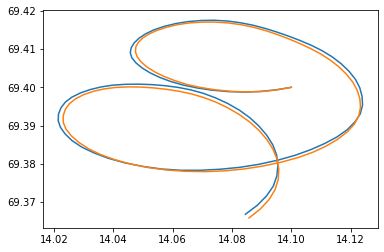

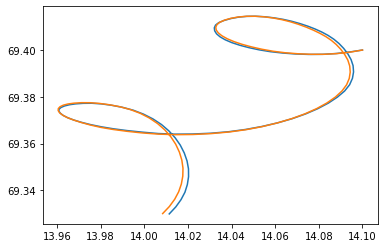

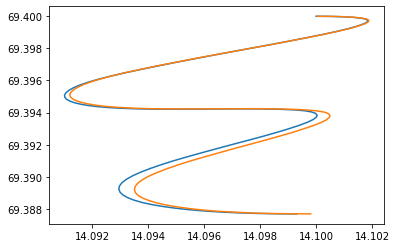

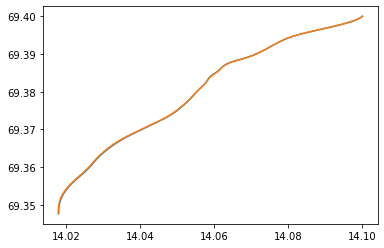

In [15]:
%matplotlib inline
plot_compare('ex1_nwnv.nc', o1)
plot_compare('ex2_wnv.nc', o2)
plot_compare('ex3_nwv.nc', o3)
plot_compare('ex4_wv.nc', o4)

In [11]:
o2.plot(fast = True, compare = [o1,o3,o4], legend = ['o2','o1','o3','o4'])

14:12:21 WARNING: plotting fast. this will make your plots less accurate.


(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f6af8bef5d0>,
 <module 'matplotlib.pyplot' from '/home/johanna/miniconda3/envs/gpuocean_parcels_opendrift/lib/python3.7/site-packages/matplotlib/pyplot.py'>)

In [12]:
#COORDINATE CHANGE ROM LON/LAT TO XY IN OPENDRIFT
def coordinate_change(o):
    t = o.get_time_array()[1]
    for i in range(len(t)):
        t[i] = t[i].total_seconds()
    t = np.array(t)

    lon, lat = o.get_lonlats()
    x,y = o.lonlat2xy(lon,lat)
    
    return t,x,y # Or save t,x,y?

In [13]:
url_list = ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc',
            '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc',
            '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc']

In [14]:
o6 = simulate_opendrift(url_list, 60.12,5.55, 0.0, True,23*3) #no wind, average velocity

14:12:23 INFO: Opening dataset: ['/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc', '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc', '/home/johanna/gpu-ocean/gpu_ocean/demos/MPI_SIR/netcdf_cache/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc']
14:12:23 INFO: Opening files with MFDataset
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  self.Dataset = xr.open_mfdataset(filename)

to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=Tru

14:13:14 INFO: 2019-07-16 06:05:00 - step 74 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:10:00 - step 75 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:15:00 - step 76 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:20:00 - step 77 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:25:00 - step 78 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:30:00 - step 79 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:35:00 - step 80 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:40:00 - step 81 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:45:00 - step 82 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:50:00 - step 83 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 06:55:00 - step 84 of 828 - 1 active elements (0 deactivated)
14:13:14 INFO: 2019-07-16 07:00:

14:13:54 INFO: 2019-07-16 13:50:00 - step 167 of 828 - 1 active elements (0 deactivated)
14:13:54 INFO: 2019-07-16 13:55:00 - step 168 of 828 - 1 active elements (0 deactivated)
14:13:54 INFO: 2019-07-16 14:00:00 - step 169 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-07-16 14:05:00 - step 170 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-07-16 14:10:00 - step 171 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-07-16 14:15:00 - step 172 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-07-16 14:20:00 - step 173 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-07-16 14:25:00 - step 174 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-07-16 14:30:00 - step 175 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-07-16 14:35:00 - step 176 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-07-16 14:40:00 - step 177 of 828 - 1 active elements (0 deactivated)
14:13:59 INFO: 2019-0

14:14:40 INFO: 2019-07-16 21:35:00 - step 260 of 828 - 1 active elements (0 deactivated)
14:14:40 INFO: 2019-07-16 21:40:00 - step 261 of 828 - 1 active elements (0 deactivated)
14:14:40 INFO: 2019-07-16 21:45:00 - step 262 of 828 - 1 active elements (0 deactivated)
14:14:40 INFO: 2019-07-16 21:50:00 - step 263 of 828 - 1 active elements (0 deactivated)
14:14:40 INFO: 2019-07-16 21:55:00 - step 264 of 828 - 1 active elements (0 deactivated)
14:14:40 INFO: 2019-07-16 22:00:00 - step 265 of 828 - 1 active elements (0 deactivated)
14:14:46 INFO: 2019-07-16 22:05:00 - step 266 of 828 - 1 active elements (0 deactivated)
14:14:46 INFO: 2019-07-16 22:10:00 - step 267 of 828 - 1 active elements (0 deactivated)
14:14:46 INFO: 2019-07-16 22:15:00 - step 268 of 828 - 1 active elements (0 deactivated)
14:14:46 INFO: 2019-07-16 22:20:00 - step 269 of 828 - 1 active elements (0 deactivated)
14:14:46 INFO: 2019-07-16 22:25:00 - step 270 of 828 - 1 active elements (0 deactivated)
14:14:46 INFO: 2019-0

KeyboardInterrupt: 

In [ ]:
o6.plot(fast = True)

In [ ]:
#60.12, 5.55

In [ ]:
lon,lat = o6.get_lonlats()
x, y = o1.lonlat2xy(5.85,60)

In [ ]:

print('x:',x/800)
print('y:',y/800)

In [ ]:

ncfile = Dataset(source_url)
for var in ncfile.variables:
    print(var)
lon = ncfile.variables['lon']
print(lon.dimensions)
lat = ncfile.variables['lat'][:]
X = ncfile.variables['X'][:]
Y = ncfile.variables['Y'][:]
ncfile.close()

In [ ]:
o = simulate_opendrift(source_url, )

In [ ]:
def xyopendrift2gpuocean(o,x0,x1,y0,y1, norkyst_X, norkyst_Y):
    lon, lat = o.get_lonlats()
    x,y = o.lonlat2xy(lon,lat)
    
    x = x - norkyst_X[x0 + 2]
    y = y- norkyst_Y[y0 + 2]
    
    return x,y
    
    
def opendriftObj2gpuoceanObs(o, x0, y1, norkyst_X, norkyst_Y):
    t = o.get_time_array()[1]
    for i in range(len(t)):
        t[i] = t[i].total_seconds()
    t = np.array(t)

    lon, lat = o.get_lonlats()
    x,y = o.lonlat2xy(lon,lat)
    
    x = x - norkyst_X[x0 + 2]
    y = y- norkyst_Y[y0 + 2]

    domain_size_x = (x1-x0-4)*800
    domain_size_y = (y1-y0-4)*800
    
    obs = Observation.Observation(domain_size_x = domain_size_x,
                                    domain_size_y = domain_size_y,
                                    nx=x1-x0-4, ny=y1-y0-4)
    
    obs.add_observations_from_arrays(t,x,y)
    
    return obs
    